## Create the Pose Detector - Landmaker

In [ ]:
# https://ai.google.dev/edge/api/mediapipe/python/mp/tasks

from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import mediapipe as mp

import matplotlib.pyplot as plt
import numpy as np
import cv2

# Model import and configuration
base_options = python.BaseOptions(model_asset_path = 'pose_landmarker.task',            
                                  delegate = None)                                      # python.Delegate.GPU -> support GPU acceleration
print(f"{base_options}\n")

# Model options
options = vision.PoseLandmarkerOptions(base_options = base_options,                     # Model options
                                       running_mode = vision.RunningMode.IMAGE,         # Running mode (IMAGE, VIDEO, LIVE_STREAM)
                                       num_poses = 1, 
                                       min_pose_detection_confidence = 0.85,            # Minimum confidence for pose detection
                                       min_tracking_confidence = 0.5,                   # Minimum confidence for pose tracking (Video, LIVE_STREAM)
                                       output_segmentation_masks = True, 
                                       result_callback = None)                          # Callback function for LIVE_STREAM mode
print(f"{options}\n")

# Create the pose landmarker - `PoseLandmarker` -> Human pose detection and tracking model
detector = vision.PoseLandmarker.create_from_options(options)
print(detector)

BaseOptions(model_asset_path='pose_landmarker.task', model_asset_buffer=None, delegate=None)

PoseLandmarkerOptions(base_options=BaseOptions(model_asset_path='pose_landmarker.task', model_asset_buffer=None, delegate=None), running_mode=<VisionTaskRunningMode.IMAGE: 'IMAGE'>, num_poses=1, min_pose_detection_confidence=0.85, min_pose_presence_confidence=0.5, min_tracking_confidence=0.5, output_segmentation_masks=True, result_callback=None)



I0000 00:00:1760886371.011818  257085 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
W0000 00:00:1760886371.098837  281112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1760886371.153416  281110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


## Detection 

`NormalizedLandmark(x, y, z, visibility, presence)`

`visibility` - Confiance que le point est visible dans l’image (non caché). 

`presence` - Confiance que le point existe vraiment (même si non visible).

In [ ]:
PATH = "images/danse.png" 

# Object Mediapipe Image (RGB) & metadata (width, height, format)
image = mp.Image.create_from_file(PATH)    #If numpy:  mp.Image(image_format=mp.ImageFormat.SRGB, data=np_image)
result = detector.detect(image)
print(result) 
print(f"Total points founded: {len(result.pose_landmarks[0])}")

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.6338072419166565, y=0.2355625480413437, z=-0.45005014538764954, visibility=0.9973100423812866, presence=0.9996380805969238), NormalizedLandmark(x=0.6442756652832031, y=0.22485454380512238, z=-0.4483706057071686, visibility=0.9952474236488342, presence=0.9995220899581909), NormalizedLandmark(x=0.6501018404960632, y=0.2243066281080246, z=-0.44903257489204407, visibility=0.9924097061157227, presence=0.9996053576469421), NormalizedLandmark(x=0.657000720500946, y=0.22375532984733582, z=-0.4488838315010071, visibility=0.9960611462593079, presence=0.9995037317276001), NormalizedLandmark(x=0.6340939998626709, y=0.2282809615135193, z=-0.4097279906272888, visibility=0.9963816404342651, presence=0.9993889331817627), NormalizedLandmark(x=0.6319864392280579, y=0.23027245700359344, z=-0.4106353521347046, visibility=0.9961681962013245, presence=0.9994832277297974), NormalizedLandmark(x=0.6291840076446533, y=0.2326791137456894, z=-0.41094639

## Optionnal -- Mask Visualization Function

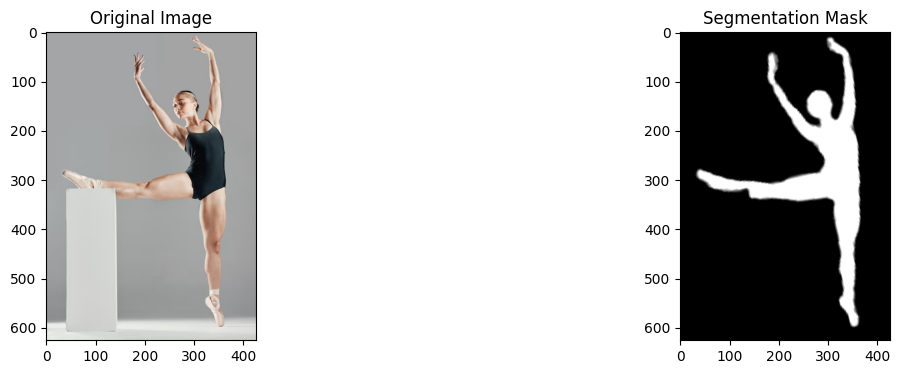

In [ ]:
mask = result.segmentation_masks[0].numpy_view()

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))
ax1.set_title("Original Image")
ax1.imshow(cv2.cvtColor(cv2.imread(PATH), cv2.COLOR_BGR2RGB))
ax2.set_title("Segmentation Mask")
ax2.imshow(mask, cmap = 'gray')
plt.show()

## Annotate Image

### Connections Options

**Naillage**
* `solutions.face_mesh.FACEMESH_TESSELATION`   # Sert pour le visage complet, modèle “Face Mesh” (468 points)
* `solutions.face_mesh.FACEMESH_CONTOURS`      # contours du visage (nez, lèvres, yeux)
* `solutions.face_mesh.FACEMESH_IRISES`       # iris des yeux
* `solutions.face_mesh.FACEMESH_LIPS`          # uniquement les lèvres
* `solutions.face_mesh.FACEMESH_LEFT_EYE`      # œil gauche
* `solutions.face_mesh.FACEMESH_RIGHT_EYE`     # œil droit
* `solutions.face_mesh.FACEMESH_LEFT_EYEBROW`  # sourcil gauche
* `solutions.face_mesh.FACEMESH_RIGHT_EYEBROW` # sourcil droit


**Combinations**
* `connections = set(itertools.chain(
    solutions.face_mesh.FACEMESH_CONTOURS,
    solutions.face_mesh.FACEMESH_IRISES))`

**Face Detection (Not Maillage)**
* `solutions.face_detection.FACEMESH_CONNECTIONS`

**Eye Model**
* `solutions.iris.IRIS_CONNECTIONS`


In [75]:
from mediapipe.framework.formats import landmark_pb2        # create landmark objects
from mediapipe import solutions                             # tools to draw representations on images


def annotate_image(image, result):
    ''' 
    Annotate Images

    '''
    np_img = image.numpy_view()
    if np_img.ndim == 3:
        np_img_bgr = cv2.cvtColor(np_img, cv2.COLOR_RGB2BGR) # Convert RGB to BGR (mediapipe format)

    annotated_image = np.copy(np_img_bgr)
    pose_landmarks = result.pose_landmarks  # taking all NormalizedLandmark


    for pose in pose_landmarks:
        pose_proto = landmark_pb2.NormalizedLandmarkList()
        for lm in pose:
            # guard: lm might be a proto or an object with attributes
            if not hasattr(lm, 'x'):
                continue
            lm_proto = landmark_pb2.NormalizedLandmark()
            lm_proto.x = lm.x
            lm_proto.y = lm.y
            lm_proto.z = getattr(lm, 'z', 0.0)
            if hasattr(lm, 'visibility'):
                lm_proto.visibility = lm.visibility
            if hasattr(lm, 'presence'):
                lm_proto.presence = lm.presence
            pose_proto.landmark.append(lm_proto)

    # draw landmarks on image
    solutions.drawing_utils.draw_landmarks(annotated_image,                                                                                      # image to draw on
                                           pose_proto,                                                                                           # landmarks to draw                     
                                           connections = solutions.pose.POSE_CONNECTIONS,                                                        # connections between landmarks
                                           landmark_drawing_spec = solutions.drawing_styles.get_default_pose_landmarks_style(),                # Point style
                                           connection_drawing_spec = solutions.drawing_utils.DrawingSpec(color = (255,0,0), thickness = 2)       # Line style
)           

    return annotated_image
    

## Optionnal -- Exemple of connections between landmarks

In [65]:
print(f'Pose Connections: {len(list(solutions.pose.POSE_CONNECTIONS))} connections')
print(solutions.pose.POSE_CONNECTIONS)
print(f'\nHand Connections: {len(list(solutions.hands.HAND_CONNECTIONS))} connections')
print(solutions.hands.HAND_CONNECTIONS)
print(f'\nFace Connections: {len(list(solutions.face_mesh.FACEMESH_TESSELATION))} connections')
print(solutions.face_mesh.FACEMESH_TESSELATION)

Pose Connections: 35 connections
frozenset({(15, 21), (16, 20), (18, 20), (3, 7), (14, 16), (23, 25), (28, 30), (11, 23), (27, 31), (6, 8), (15, 17), (24, 26), (16, 22), (4, 5), (5, 6), (29, 31), (12, 24), (23, 24), (0, 1), (9, 10), (1, 2), (0, 4), (11, 13), (30, 32), (28, 32), (15, 19), (16, 18), (25, 27), (26, 28), (12, 14), (17, 19), (2, 3), (11, 12), (27, 29), (13, 15)})

Hand Connections: 21 connections
frozenset({(3, 4), (0, 5), (17, 18), (0, 17), (13, 14), (13, 17), (18, 19), (5, 6), (5, 9), (14, 15), (0, 1), (9, 10), (1, 2), (9, 13), (10, 11), (19, 20), (6, 7), (15, 16), (2, 3), (11, 12), (7, 8)})

Face Connections: 2556 connections
frozenset({(18, 17), (82, 38), (8, 9), (456, 248), (167, 2), (303, 271), (69, 104), (253, 450), (41, 42), (315, 16), (73, 74), (339, 373), (258, 385), (105, 63), (219, 48), (304, 272), (236, 217), (231, 22), (85, 84), (365, 367), (237, 218), (243, 112), (436, 427), (409, 410), (248, 456), (330, 266), (136, 135), (88, 95), (394, 430), (107, 108), (11

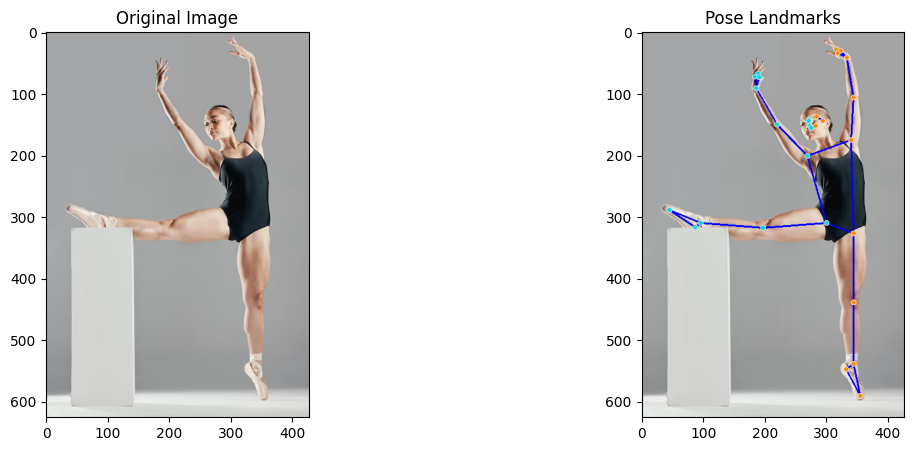

In [76]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
plt.subplots_adjust(wspace = 0.05)

ax1.set_title('Original Image')
image = cv2.imread(PATH)
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

ax2.set_title('Pose Landmarks')
image = mp.Image.create_from_file(PATH)
detection_results = detector.detect(image)
annotated_image = annotate_image(image, detection_results)
ax2.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.show()